In [1]:
import pandas as pd
df_oct = pd.read_csv('oct2024.csv')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df = df_oct.copy()

In [3]:
# =========================
# GBM residual experiment (p50 / p85)
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

# ---- 0) CONFIG (pick 1–2 months to train, next month to test) ----
TRAIN_FROM = "2024-10-01"
TRAIN_TO   = "2024-10-15"
TEST_FROM  = "2024-10-16"
TEST_TO    = "2024-10-31"

# Optional: focus on a line to prototype (e.g., [18]); set to None for all lines
FOCUS_LINES = None#[18,80]   # e.g., [18]

# ---- 1) BASIC CLEANUP ----
# Parse times we need (convert if present)
time_cols = [
    "DTDepartTheo","DTArriveeTheo","DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
    "DTEntreeArretAtp","DTSortieArretAtp",
    "DTMarquageArretTheo","DTMarquageArretReal"
]
for c in time_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")


# (Optional) line filter for quick prototyping
if FOCUS_LINES is not None and "C_Ligne" in df.columns:
    df["C_Ligne"] = pd.to_numeric(df["C_Ligne"], errors="coerce")
    df = df[df["C_Ligne"].isin(FOCUS_LINES)]

# Keep essentials as strings/numerics
df["CodeLong"] = df["CodeLong"].astype(str).str.strip()
if "C_SensAppl" in df.columns:
    df["C_SensAppl"] = df["C_SensAppl"].astype(str).str.strip()

# ---- 2) BUILD SEGMENT ROWS (prev stop -> current stop) ----
df = df.sort_values(["IdCourse","RangArretAsc"], kind="mergesort")

# upstream (prev) columns
df["prev_CodeLong"]              = df.groupby("IdCourse")["CodeLong"].shift(1)
df["prev_DTSortieFenetreReal"]   = df.groupby("IdCourse")["DTSortieFenetreArretReal"].shift(1)
df["prev_DTSortieAtp"]           = df.groupby("IdCourse")["DTSortieArretAtp"].shift(1)
df["prev_DTMarquageTheo"]        = df.groupby("IdCourse")["DTMarquageArretTheo"].shift(1)
df["prev_DTDepartTheo"]          = df.groupby("IdCourse")["DTDepartTheo"].shift(1)
df["prev_dwell_window_s"]        = (
    df.groupby("IdCourse")["DTSortieFenetreArretReal"].shift(1) - 
    df.groupby("IdCourse")["DTEntreeFenetreArretReal"].shift(1)
).dt.total_seconds()

# demand / punctuality at upstream stop
for c in ["NbMontees","NbDescentes","EcartDepart"]:
    if c in df.columns:
        df[f"prev_{c}"] = pd.to_numeric(df.groupby("IdCourse")[c].shift(1), errors="coerce")

# Distance of the current link
if "DistanceInterArret" in df.columns:
    df["DistanceInterArret"] = pd.to_numeric(df["DistanceInterArret"], errors="coerce")
elif "DistanceTheo" in df.columns:
    df["DistanceInterArret"] = pd.to_numeric(df["DistanceTheo"], errors="coerce")
else:
    df["DistanceInterArret"] = np.nan

# Keep rows where a previous stop exists (i.e., a link is defined)
seg = df.dropna(subset=["prev_CodeLong"]).copy()
seg["from_stop"] = seg["prev_CodeLong"].astype(str).str.strip()
seg["to_stop"]   = seg["CodeLong"].astype(str).str.strip()
seg["SegmentKey"] = seg["from_stop"] + "→" + seg["to_stop"]


In [4]:
# --- Clean target definitions based on EcartDepart ---

# 1) E_i and E_prev (both numeric)
seg["E_i"]    = pd.to_numeric(seg.get("EcartDepart"), errors="coerce")
seg["E_prev"] = pd.to_numeric(seg.get("prev_EcartDepart"), errors="coerce")

# 2) Delta E between stops (delay propagation)
seg["dE"] = seg["E_i"] - seg["E_prev"]

# 3) Upstream dwell (window) -- already computed upstream
seg["dwell_prev_s"] = seg["prev_dwell_window_s"]

# 4) Distance (static; keep simple and consistent)
seg["distance_m"] = pd.to_numeric(seg["DistanceInterArret"], errors="coerce") - 70.0
seg.loc[seg["distance_m"] <= 0, "distance_m"] = np.nan

# 5) Time anchors: use previous scheduled departure as link start time
seg["link_start_time"] = seg["prev_DTDepartTheo"]
seg = seg[pd.notna(seg["link_start_time"])].copy()
seg["hour"] = seg["link_start_time"].dt.hour
seg["dow"]  = seg["link_start_time"].dt.dayofweek
seg["is_weekend"] = seg["dow"].isin([5,6]).astype(int)
seg["hour_sin"] = np.sin(2*np.pi*seg["hour"]/24.0)
seg["hour_cos"] = np.cos(2*np.pi*seg["hour"]/24.0)

In [5]:

# ---- 5) FEATURES ----
# Physics-like speed feature (using window-to-window time & minus 70m windows)
seg["distance_m"] = seg["DistanceInterArret"] - 70.0
seg.loc[seg["distance_m"] <= 0, "distance_m"] = np.nan

# Upstream dwell (window)
seg["dwell_prev_s"] = seg["prev_dwell_window_s"]

# Time context from upstream scheduled departure
seg["link_start_time"] = seg["prev_DTDepartTheo"]  # anchor time for the link
seg = seg[pd.notna(seg["link_start_time"])].copy()
seg["hour"] = seg["link_start_time"].dt.hour
seg["dow"]  = seg["link_start_time"].dt.dayofweek
seg["month"]= seg["link_start_time"].dt.month
seg["is_weekend"] = seg["dow"].isin([5,6]).astype(int)
seg["hour_sin"] = np.sin(2*np.pi*seg["hour"]/24.0)
seg["hour_cos"] = np.cos(2*np.pi*seg["hour"]/24.0)

# Punctuality & demand (upstream)
if "prev_EcartDepart" in seg.columns:
    seg["ecart_prev_s"] = seg["prev_EcartDepart"]
else:
    seg["ecart_prev_s"] = np.nan

seg["board_prev"] = seg.get("prev_NbMontees", np.nan)
seg["alight_prev"] = seg.get("prev_NbDescentes", np.nan)

# Identifiers
seg["line"] = seg.get("C_Ligne", np.nan).astype(str)
seg["dir"]  = seg.get("C_SensAppl", np.nan).astype(str)


In [6]:
# Historical baseline bins (periods) for later
def assign_period(dt):
    h = dt.hour; d = dt.dayofweek
    if d==5: return "Sat"
    if d==6: return "Sun"
    if 7<=h<9:   return "AM"
    if 9<=h<16:  return "Day"
    if 16<=h<19: return "PM"
    if 19<=h<23: return "Eve"
    return "Other"
seg["period"] = seg["link_start_time"].map(assign_period)

# Final feature set
feat_cols = [
    "distance_m","phys_speed_kmh","dwell_prev_s","ecart_prev_s",
    "board_prev","alight_prev",
    "hour_sin","hour_cos","dow","is_weekend",
    "from_stop","to_stop","line","dir"
]


In [7]:
# =========================
#  GBM for E and ΔE (p50 / p85)
#  - same time-aware split
#  - native categorical with logs + early stopping
#  - robust baselines for both targets
# =========================
import os, gc, time, warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
from pandas.api.types import CategoricalDtype
warnings.filterwarnings("ignore", message=".*dask-expr.*", category=FutureWarning)

# -------- 0) CONFIG (沿用你的區段) --------
TRAIN_FROM = "2024-10-01"
TRAIN_TO   = "2024-10-15"
TEST_FROM  = "2024-10-16"
TEST_TO    = "2024-10-31"

# -------- 1) TIME-AWARE SPLIT --------
mask_tr = (seg["link_start_time"]>=pd.to_datetime(TRAIN_FROM)) & (seg["link_start_time"]<=pd.to_datetime(TRAIN_TO))
mask_te = (seg["link_start_time"]>=pd.to_datetime(TEST_FROM))  & (seg["link_start_time"]<=pd.to_datetime(TEST_TO))
train = seg[mask_tr].copy()
test  = seg[mask_te].copy()

# 便於 baseline 的「period」健全
train["period"] = train["period"].fillna("Other").astype(str)
test["period"]  = test["period"].fillna("Other").astype(str)

# -------- 2) FEATURES（建議用 E_prev 取代舊的 ecart_prev_s 名稱） --------
feat_cols = [
    "distance_m","dwell_prev_s","E_prev",     # 用明確名稱 E_prev
    "board_prev","alight_prev",
    "hour_sin","hour_cos","dow","is_weekend",
    "from_stop","to_stop","line","dir"
]
cat_cols = ["from_stop","to_stop","line","dir"]
num_cols = [c for c in feat_cols if c not in cat_cols]

# -------- 3) 準備兩個 target：E 與 ΔE --------
# E target
train_E = train.dropna(subset=["E_i","E_prev"]).copy()
test_E  = test.dropna(subset=["E_i","E_prev"]).copy()   # for fair metric vs naive prev/zero
y_E_tr  = train_E["E_i"].astype(float).values
y_E_te  = test_E["E_i"].astype(float).values

# ΔE target
train_dE = train.dropna(subset=["dE","E_prev"]).copy()
test_dE  = test.dropna(subset=["dE","E_prev"]).copy()
y_dE_tr  = train_dE["dE"].astype(float).values
y_dE_te  = test_dE["dE"].astype(float).values

# -------- 4) Hist baselines（以 Segment×period 聚合） --------
def qmap(series):
    # 產出 p50 / p85 的 Series（MultiIndex: (SegmentKey, period)）
    g = series.groupby([series.index.get_level_values(0), series.index.get_level_values(1)])
    return g.median(), g.quantile(0.85)

# E 的歷史 baseline
hist_E_p50 = (train_E
              .groupby(["SegmentKey","period"])["E_i"]
              .median())
hist_E_p85 = (train_E
              .groupby(["SegmentKey","period"])["E_i"]
              .quantile(0.85))

# ΔE 的歷史 baseline
hist_dE_p50 = (train_dE
               .groupby(["SegmentKey","period"])["dE"]
               .median())
hist_dE_p85 = (train_dE
               .groupby(["SegmentKey","period"])["dE"]
               .quantile(0.85))

def baseline_from_hist_fast(dfX: pd.DataFrame, qseries: pd.Series, default=0.0) -> np.ndarray:
    out = (dfX[["SegmentKey","period"]]
           .merge(qseries.rename("q"),
                  left_on=["SegmentKey","period"],
                  right_index=True, how="left")["q"]
           .fillna(default)
           .to_numpy(dtype=float))
    return out

# -------- 5) 準備 X（E 與 ΔE 路徑各自取對應資料） --------
def build_X(dfX):
    X = dfX[feat_cols].copy()
    # 數值清理
    X[num_cols] = X[num_cols].replace([np.inf, -np.inf], np.nan)
    # 丟掉數值 NaN（也可以先做簡單填補，但先保守）
    mask = np.all(np.isfinite(X[num_cols].to_numpy()), axis=1)
    return X.iloc[mask].copy(), mask

X_E_tr, mE_tr = build_X(train_E)
y_E_tr = y_E_tr[mE_tr]
X_E_te, mE_te = build_X(test_E)
y_E_te = y_E_te[mE_te]

X_dE_tr, mdE_tr = build_X(train_dE)
y_dE_tr = y_dE_tr[mdE_tr]
X_dE_te, mdE_te = build_X(test_dE)
y_dE_te = y_dE_te[mdE_te]

# 小尾巴當 validation（各自計算）
def split_tail(dfX):
    VAL_DAYS = 3
    val_cut = pd.to_datetime(TRAIN_TO) - pd.Timedelta(days=VAL_DAYS-1)
    return dfX["link_start_time"] >= val_cut

val_mask_E  = split_tail(train_E.iloc[mE_tr])
val_mask_dE = split_tail(train_dE.iloc[mdE_tr])

X_E_fit = X_E_tr.loc[~val_mask_E].copy()
y_E_fit = y_E_tr[~val_mask_E.values]
X_E_val = X_E_tr.loc[val_mask_E].copy()
y_E_val = y_E_tr[val_mask_E.values]

X_dE_fit = X_dE_tr.loc[~val_mask_dE].copy()
y_dE_fit = y_dE_tr[~val_mask_dE.values]
X_dE_val = X_dE_tr.loc[val_mask_dE].copy()
y_dE_val = y_dE_tr[val_mask_dE.values]

# -------- 6) 讓類別欄位詞彙一致（E 與 ΔE 各自做一次） --------
def align_cats(X_fit, X_val, X_te, cats):
    for c in cats:
        catset = sorted(set(X_fit[c].astype(str)) | set(X_val[c].astype(str)) | set(X_te[c].astype(str)) | {"OTHER"})
        ctype  = CategoricalDtype(categories=catset, ordered=False)
        X_fit[c] = X_fit[c].astype(ctype)
        X_val[c] = X_val[c].astype(ctype)
        X_te[c]  = X_te[c].astype(ctype)
    cat_idx = [X_fit.columns.get_loc(c) for c in cats]
    return cat_idx

# 先 cap rare，避免超高基數（兩路一致處理）
def cap_rare_inplace(dfX, cols, min_count=50):
    for c in cols:
        vc = dfX[c].astype(str).value_counts()
        keep = set(vc[vc >= min_count].index)
        dfX[c] = dfX[c].astype(str).where(dfX[c].astype(str).isin(keep), "OTHER")

for dset in [X_E_fit, X_E_val, X_E_te, X_dE_fit, X_dE_val, X_dE_te]:
    cap_rare_inplace(dset, cat_cols, min_count=50)

cat_idx_E  = align_cats(X_E_fit,  X_E_val,  X_E_te,  cat_cols)
cat_idx_dE = align_cats(X_dE_fit, X_dE_val, X_dE_te, cat_cols)

# 數值壓成 float32（加速 & 省記憶體）
for dset in [X_E_fit, X_E_val, X_E_te, X_dE_fit, X_dE_val, X_dE_te]:
    dset[num_cols] = dset[num_cols].astype("float32")

# -------- 7) LightGBM 參數 + 訓練函式（印出 [20] 日誌） --------
os.environ.setdefault("OMP_NUM_THREADS", "2")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("BLIS_NUM_THREADS", "1")

base_params = dict(
    learning_rate=0.10,
    n_estimators=600,
    max_depth=6,
    num_leaves=31,
    min_data_in_leaf=500,
    max_bin=63,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    n_jobs=2,
    force_row_wise=True,
    max_cat_to_onehot=4,
    max_cat_threshold=16,
    min_data_per_group=100,
    cat_smooth=10
)

def train_pair(X_fit, y_fit, X_val, y_val, X_te, cat_idx, label="(target)"):
    # p50 with L1
    print(f">>> train p50 {label}", flush=True)
    t0 = time.time()
    m50 = lgb.LGBMRegressor(objective="regression_l1", **base_params)
    m50.fit(
        X_fit, y_fit,
        eval_set=[(X_val, y_val)],
        eval_metric="l1",
        categorical_feature=cat_idx,
        callbacks=[lgb.log_evaluation(period=20),
                   lgb.early_stopping(stopping_rounds=30)]
    )
    print(f"<<< p50 done in {time.time()-t0:.2f}s, best_iter={getattr(m50,'best_iteration_',None)}")

    # p85 with quantile
    print(f">>> train p85 {label}", flush=True)
    t1 = time.time()
    m85 = lgb.LGBMRegressor(objective="quantile", alpha=0.85, **base_params)
    m85.fit(
        X_fit, y_fit,
        eval_set=[(X_val, y_val)],
        eval_metric="quantile",
        categorical_feature=cat_idx,
        callbacks=[lgb.log_evaluation(period=20),
                   lgb.early_stopping(stopping_rounds=30)]
    )
    print(f"<<< p85 done in {time.time()-t1:.2f}s, best_iter={getattr(m85,'best_iteration_',None)}")

    # predict
    pred50 = m50.predict(X_te, num_iteration=getattr(m50,"best_iteration_",None))
    pred85 = m85.predict(X_te, num_iteration=getattr(m85,"best_iteration_",None))
    return pred50, pred85, m50, m85

# -------- 8) 兩路訓練：E 與 ΔE --------
import gc

# ==== Train E only ====
predE50, predE85, mE50, mE85 = train_pair(X_E_fit, y_E_fit, X_E_val, y_E_val, X_E_te, cat_idx_E, label="(E)")

# Free E intermediates early
del X_E_fit, X_E_val, X_E_te, y_E_fit, y_E_val, y_E_te
gc.collect()

# ==== Train ΔE only ====
preddE50, preddE85, mDE50, mDE85 = train_pair(X_dE_fit, y_dE_fit, X_dE_val, y_dE_val, X_dE_te, cat_idx_dE, label="(ΔE)")

# Free ΔE intermediates if not needed
del X_dE_fit, X_dE_val, X_dE_te, y_dE_fit, y_dE_val, y_dE_te
gc.collect()

/Users/ching-chichou/opt/anaconda3/envs/ada/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


>>> train p50 (E)
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0

41

In [ ]:
print('done')

In [ ]:
# ====== POST-TRAIN: robust, timed, and baseline-optional ======
import time, numpy as np, pandas as pd

def lap(msg, _t=[None]):
    now = time.time()
    if _t[0] is None:
        print(f"[{msg}]"); _t[0] = now
    else:
        print(f"[{msg}] {now - _t[0]:.2f}s"); _t[0] = now

# 0) Optional: silence the dask FutureWarning
import warnings
warnings.filterwarnings("ignore", message=".*dask-expr.*", category=FutureWarning)

# 1) Predict (fast)
lap("predict E / ΔE")
predE50  = mE50.predict(X_E_te,  num_iteration=getattr(mE50, "best_iteration_", None))
predE85  = mE85.predict(X_E_te,  num_iteration=getattr(mE85, "best_iteration_", None))
preddE50 = mDE50.predict(X_dE_te, num_iteration=getattr(mDE50,"best_iteration_", None))
preddE85 = mDE85.predict(X_dE_te, num_iteration=getattr(mDE85,"best_iteration_", None))
lap("predict done")

# 2) Reconstruct E via ΔE     (Ê_i = E_prev + ΔÊ_i)
lap("reconstruct E via ΔE")
Eprev_te = test["E_prev"].to_numpy(dtype=float)        # already aligned to X_dE_te
Ehat_via_dE_p50 = Eprev_te + preddE50
Ehat_via_dE_p85 = Eprev_te + preddE85
lap("reconstruct done")

# 3) Metrics without baselines (instant)
lap("metrics (no baseline)")
def mae(a, b): return float(np.mean(np.abs(a - b)))
Ey = y_E_te  # true E_i on test
print("\n=== Metrics (quick) ===")
print(f"MAE(E) direct p50   : {mae(Ey, predE50):.2f}")
print(f"MAE(E) via ΔE (p50) : {mae(Ey, Ehat_via_dE_p50):.2f}")
print(f"MAE(E) naive prev   : {mae(Ey, Eprev_te):.2f}")
print(f"Cov@p85 direct      : {float(np.mean(Ey <= predE85)):.3f}")
print(f"Cov@p85 via ΔE      : {float(np.mean(Ey <= Ehat_via_dE_p85)):.3f}")
lap("metrics done")

# 4) (Optional) Slow baselines — turn OFF first; flip to True only若你要比
# DO_BASELINES = False
# if DO_BASELINES:
#     lap("build historical baselines (E)")
#     # E 的歷史中位 & p85
#     hist_E_p50 = train.groupby(["SegmentKey","period"])["E_i"].median()
#     hist_E_p85 = train.groupby(["SegmentKey","period"])["E_i"].quantile(0.85)

#     def baseline_from_hist_fast(dfX: pd.DataFrame, qseries: pd.Series, default=0.0) -> np.ndarray:
#         out = (dfX[["SegmentKey","period"]]
#                .merge(qseries.rename("q"), left_on=["SegmentKey","period"], right_index=True, how="left")["q"]
#                .fillna(default)
#                .to_numpy(dtype=float))
#         return out

#     bE50 = baseline_from_hist_fast(test, hist_E_p50, default=0.0)
#     bE85 = baseline_from_hist_fast(test, hist_E_p85, default=0.0)
#     lap("baselines done")

#     print("\n=== Metrics vs Baselines (E) ===")
#     print(f"MAE(E) hist p50     : {mae(Ey, bE50):.2f}")
#     print(f"Cov@p85 hist        : {float(np.mean(Ey <= bE85)):.3f}")

In [40]:
import numpy as np
import pandas as pd

# 1) 基本整理：確保排序與型別
gdf = df.copy()

# 只看同一趟車的相鄰站（IdCourse + RangArretAsc）
gdf = gdf.sort_values(["IdCourse", "RangArretAsc"], kind="mergesort")

# 轉數值/時間
gdf["EcartDepart"] = pd.to_numeric(gdf["EcartDepart"], errors="coerce")
gdf["CodeLong"] = gdf["CodeLong"].astype(str).str.strip()
if "C_Ligne" in gdf.columns:
    gdf["C_Ligne"] = gdf["C_Ligne"].astype(str)
if "C_SensAppl" in gdf.columns:
    gdf["C_SensAppl"] = gdf["C_SensAppl"].astype(str)

# 2) 取「上一站」的 Ecart、站碼
gdf["E_prev"] = gdf.groupby("IdCourse")["EcartDepart"].shift(1)
gdf["prev_stop"] = gdf.groupby("IdCourse")["CodeLong"].shift(1)

# 3) 組出 link 層級的表：上一站 → 本站
links = gdf.dropna(subset=["E_prev", "EcartDepart", "prev_stop", "CodeLong"]).copy()
links = links.rename(columns={"EcartDepart":"E_curr"})
links["SegmentKey"] = links["prev_stop"] + "→" + links["CodeLong"]

# 4) 時間分段（可用來分 AM/PM 分析）
def assign_period(dt):
    if pd.isna(dt): return "Other"
    h = dt.hour; d = dt.dayofweek
    if d == 5: return "Sat"
    if d == 6: return "Sun"
    if 7<=h<9:   return "AM"
    if 9<=h<16:  return "Day"
    if 16<=h<19: return "PM"
    if 19<=h<23: return "Eve"
    return "Other"

if "DTDepartTheo" in gdf.columns:
    links["period"] = gdf["DTDepartTheo"].map(assign_period)
else:
    links["period"] = "NA"

# 5) 去除極端值（避免少數爆點支配統計；閾值可調）
links = links[(links["E_prev"].between(-1800, 1800)) & (links["E_curr"].between(-1800, 1800))]

print("Links (pairs) sample size:", len(links))
links.head(3)

Links (pairs) sample size: 317365


,IdCourse,IdArret,RangArretAsc,DateCourse,HDepartTheo,HArriveeTheo,DistanceTheo,TempsInterArretTheo,E_curr,EcartDistance,...,prev_DTMarquageTheo,prev_DTDepartTheo,prev_dwell_window_s,prev_NbMontees,prev_NbDescentes,prev_EcartDepart,E_prev,prev_stop,SegmentKey,period
769,83732743,801,2,2024-10-01,00:56:00,00:56:00,328,80,40,3,...,2024-10-01 00:54:40,2024-10-01 00:54:00,67.0,1.0,0.0,7.0,7.0,CVIN04,CVIN04→LYON01,Other
1013,83732743,1082,3,2024-10-01,00:57:42,00:57:42,742,102,37,4,...,2024-10-01 00:56:00,2024-10-01 00:56:00,36.0,1.0,0.0,40.0,40.0,LYON01,LYON01→POTE01,Other
1251,83732743,1238,4,2024-10-01,00:58:20,00:58:20,1059,78,10,5,...,2024-10-01 00:57:42,2024-10-01 00:57:42,50.0,0.0,0.0,37.0,37.0,POTE01,POTE01→SERV01,Other


In [41]:
# 1) 整體線性相關（Pearson）與秩相關（Spearman）
pear = links[["E_prev","E_curr"]].corr(method="pearson").iloc[0,1]
spear = links[["E_prev","E_curr"]].corr(method="spearman").iloc[0,1]
print(f"Correlation (Pearson): {pear:.3f} | Spearman: {spear:.3f}")

# 2) 斜率（E_curr ≈ a + b * E_prev）：b 接近 1 ⇒ 強傳遞（delay 幾乎不被回收）
b = np.polyfit(links["E_prev"].values, links["E_curr"].values, deg=1)[0]
print(f"Slope b from OLS (no intercept shown): {b:.3f}")

# 3) ΔE = E_curr - E_prev 的統計（中位數 / 分位數）
links["dE"] = links["E_curr"] - links["E_prev"]
q = links["dE"].quantile([0.1,0.25,0.5,0.75,0.9]).round(1)
print("ΔE quantiles (s):")
print(q.to_string())

Correlation (Pearson): 0.959 | Spearman: 0.948
Slope b from OLS (no intercept shown): 0.992
ΔE quantiles (s):
0.10   -27.0
0.25   -14.0
0.50    -1.0
0.75    13.0
0.90    35.0


In [42]:
def propagation_report(thr_prev=300, tol_same=60):
    """
    thr_prev: 以「上一站延遲幅度」篩選（秒），例如 300=5分鐘
    tol_same: 認定「幾乎同樣延遲」的容差（秒）
    """
    sub = links[links["E_prev"].abs() >= thr_prev].copy()
    if len(sub)==0:
        print(f"No samples with |E_prev| >= {thr_prev}s"); 
        return
    same_sign = np.mean(np.sign(sub["E_prev"]) == np.sign(sub["E_curr"]))
    near_same = np.mean((sub["E_curr"] - sub["E_prev"]).abs() <= tol_same)
    partial_recovery = np.mean(sub["E_curr"].abs() <= 0.5 * sub["E_prev"].abs())
    avg_delta = sub["dE"].median()

    print(f"[|E_prev|>={thr_prev}s] n={len(sub):,}")
    print(f"  P(sign(E_curr) == sign(E_prev))         = {same_sign:.3f}")
    print(f"  P(|E_curr - E_prev| <= {tol_same:>3d}s) = {near_same:.3f}   (≈幾乎同樣延遲)")
    print(f"  P(|E_curr| <= 0.5*|E_prev|)             = {partial_recovery:.3f}   (部分回收)")
    print(f"  median(ΔE)                               = {avg_delta:.1f}s")

# 看 1 分鐘、2 分鐘、5 分鐘門檻
for thr in [60, 120, 300]:
    propagation_report(thr_prev=thr, tol_same=60)

[|E_prev|>=60s] n=174,403
  P(sign(E_curr) == sign(E_prev))         = 0.992
  P(|E_curr - E_prev| <=  60s) = 0.936   (≈幾乎同樣延遲)
  P(|E_curr| <= 0.5*|E_prev|)             = 0.030   (部分回收)
  median(ΔE)                               = -1.0s
[|E_prev|>=120s] n=93,405
  P(sign(E_curr) == sign(E_prev))         = 0.996
  P(|E_curr - E_prev| <=  60s) = 0.929   (≈幾乎同樣延遲)
  P(|E_curr| <= 0.5*|E_prev|)             = 0.010   (部分回收)
  median(ΔE)                               = 0.0s
[|E_prev|>=300s] n=20,757
  P(sign(E_curr) == sign(E_prev))         = 0.997
  P(|E_curr - E_prev| <=  60s) = 0.905   (≈幾乎同樣延遲)
  P(|E_curr| <= 0.5*|E_prev|)             = 0.006   (部分回收)
  median(ΔE)                               = 1.0s


In [43]:
# 將 E_prev 分箱，觀察 E_curr 的條件中位數/分位數
bins = [-1200,-600,-300,-120,-60,-30,0,30,60,120,300,600,1200]
labels = [f"{bins[i]}~{bins[i+1]}s" for i in range(len(bins)-1)]
links["Eprev_bin"] = pd.cut(links["E_prev"], bins=bins, labels=labels, include_lowest=True)

tbl = (links.groupby("Eprev_bin")
              .agg(n=("E_curr","size"),
                   median_Ecurr=("E_curr","median"),
                   p25=("E_curr", lambda x: x.quantile(0.25)),
                   p75=("E_curr", lambda x: x.quantile(0.75)))
              .reset_index())
tbl

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_23677/2649422945.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tbl = (links.groupby("Eprev_bin")


,Eprev_bin,n,median_Ecurr,p25,p75
0,-1200~-600s,190,-727.0,-974.0,-635.25
1,-600~-300s,277,-360.0,-449.0,-246.00
2,-300~-120s,6336,-144.0,-173.0,-121.00
3,-120~-60s,19836,-81.0,-101.0,-62.00
4,-60~-30s,23179,-43.0,-57.0,-27.00
5,-30~0s,35633,-14.0,-28.0,2.00
6,0~30s,44738,15.0,1.0,31.00
7,30~60s,40644,44.0,29.0,59.00
8,60~120s,60695,86.0,67.0,106.00
9,120~300s,65676,178.0,143.0,225.00


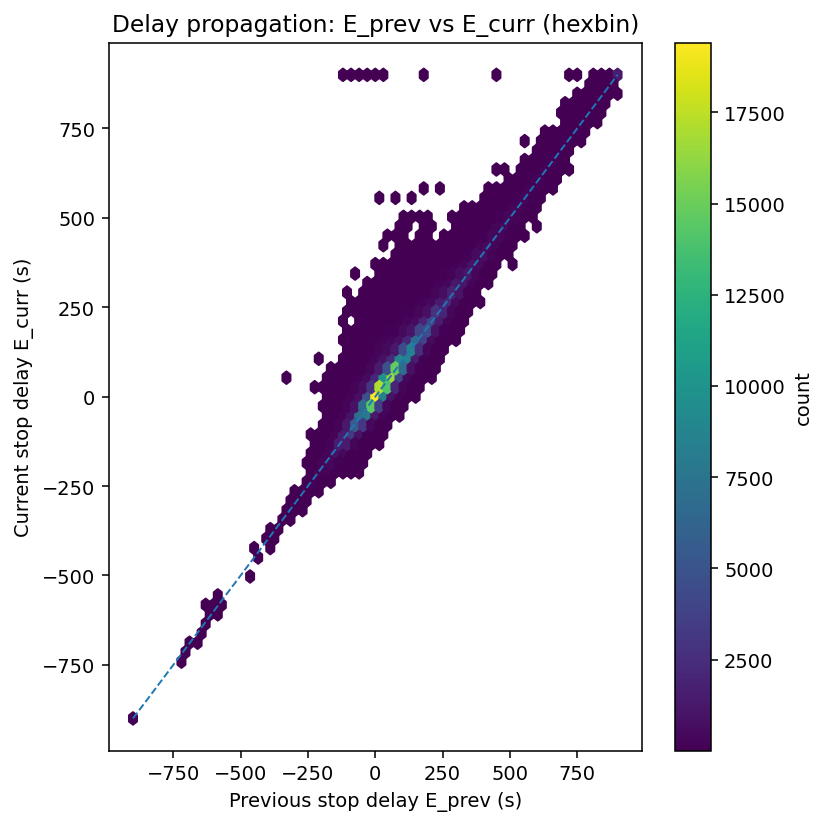

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6), dpi=140)
clip = 900  # 圖面範圍：±15 分鐘
x = links["E_prev"].clip(-clip, clip)
y = links["E_curr"].clip(-clip, clip)

hb = plt.hexbin(x, y, gridsize=60, mincnt=5, cmap="viridis")
plt.colorbar(hb, label="count")

# 45度線（純傳遞）
xx = np.linspace(-clip, clip, 100)
plt.plot(xx, xx, linestyle="--", linewidth=1)

plt.xlabel("Previous stop delay E_prev (s)")
plt.ylabel("Current stop delay E_curr (s)")
plt.title("Delay propagation: E_prev vs E_curr (hexbin)")
plt.tight_layout()
plt.show()

Pairs by line: {'18': 180285, '80': 137080}


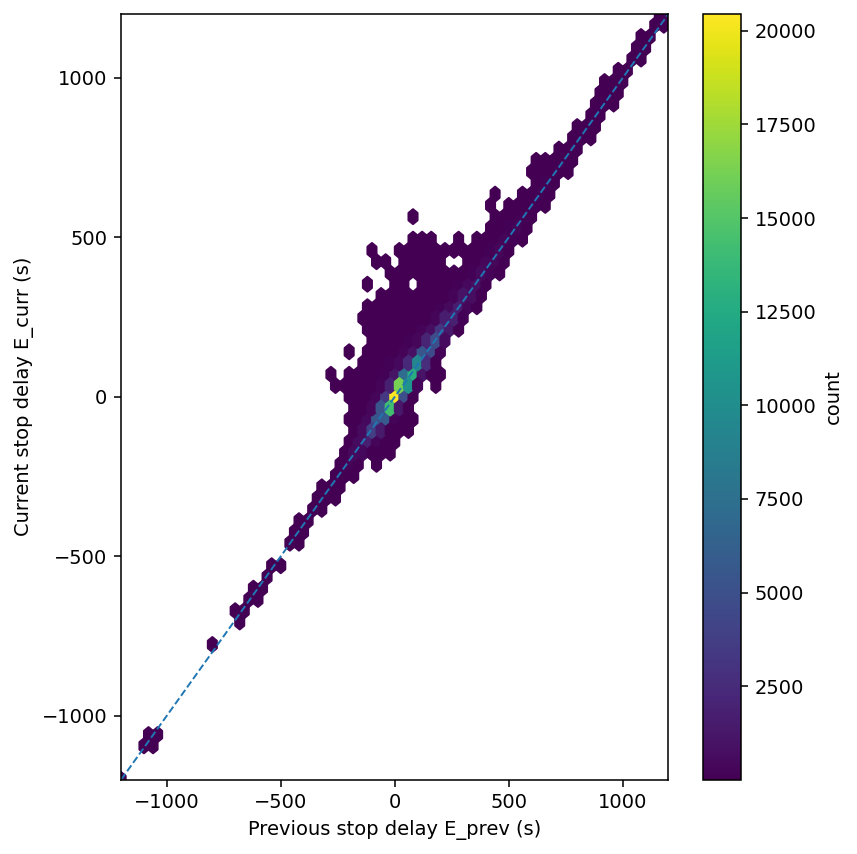

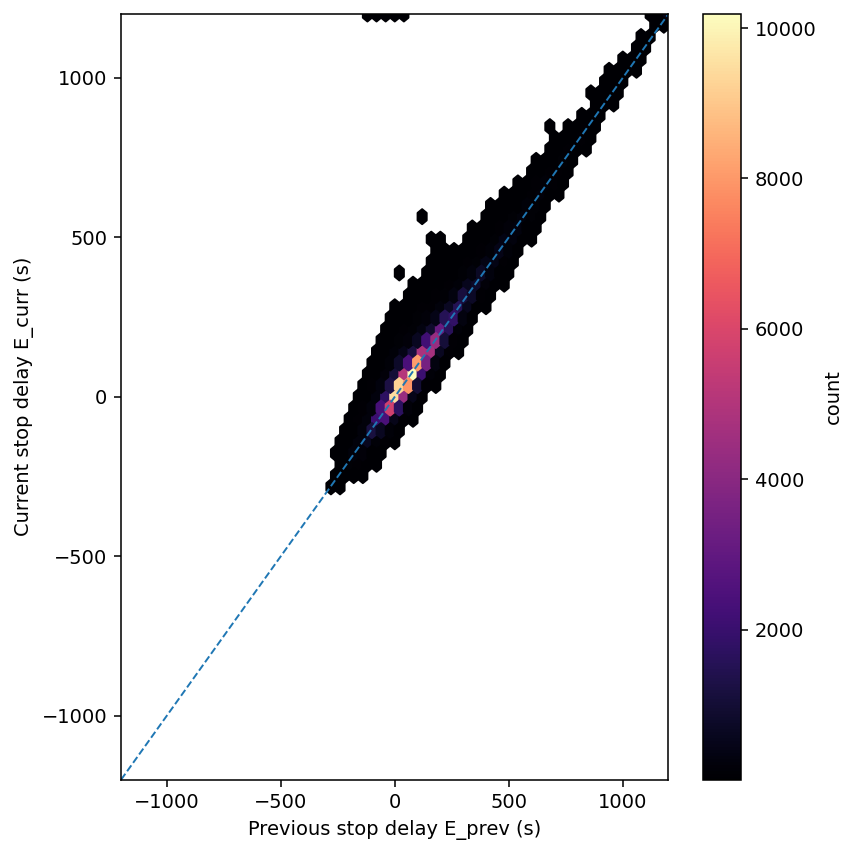

In [50]:
# Split by line (18 vs 80) and plot with same axis scales

import numpy as np
import matplotlib.pyplot as plt

# ensure line code is string for filtering
links["C_Ligne"] = links["C_Ligne"].astype(str).str.strip()

# filter two lines
L18 = links[links["C_Ligne"] == "18"].copy()
L80 = links[links["C_Ligne"] == "80"].copy()

print("Pairs by line:", {k: len(v) for k, v in {"18": L18, "80": L80}.items()})

# consistent axis limits ±600 s
clip = 1200
xlim = (-clip, clip)
ylim = (-clip, clip)

# compute simple stats for titles
def stats_text(df):
    if len(df) == 0:
        return "n=0"
    pear = df[["E_prev","E_curr"]].corr(method="pearson").iloc[0,1]
    # slope b from OLS y ~ b*x (no intercept shown for brevity)
    b = np.polyfit(df["E_prev"].values, df["E_curr"].values, deg=1)[0]
    return f"n={len(df):,} | r={pear:.2f} | slope={b:.2f}"

# prepare clipped copies for plotting
for d in (L18, L80):
    d["x"] = d["E_prev"].clip(*xlim)
    d["y"] = d["E_curr"].clip(*ylim)

# draw two separate figures with different colormaps but same axis scales
# --- Line 18 ---
plt.figure(figsize=(6.2,6.2), dpi=140)
hb = plt.hexbin(L18["x"], L18["y"], gridsize=60, mincnt=5, cmap="viridis")
plt.colorbar(hb, label="count")
xx = np.linspace(*xlim, 100)
plt.plot(xx, xx, "--", linewidth=1)  # 45-degree line (pure propagation)

plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel("Previous stop delay E_prev (s)")
plt.ylabel("Current stop delay E_curr (s)")
#plt.title(f"Delay propagation (Line 18) — {stats_text(L18)}")
plt.tight_layout()
plt.show()

# --- Line 80 ---
plt.figure(figsize=(6.2,6.2), dpi=140)
hb = plt.hexbin(L80["x"], L80["y"], gridsize=60, mincnt=5, cmap="magma")
plt.colorbar(hb, label="count")
xx = np.linspace(*xlim, 100)
plt.plot(xx, xx, "--", linewidth=1)

plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel("Previous stop delay E_prev (s)")
plt.ylabel("Current stop delay E_curr (s)")
#plt.title(f"Delay propagation (Line 80) — {stats_text(L80)}")
plt.tight_layout()
plt.show()

In [69]:
# --- Configure target: "E" (departure deviation) and "dE" (delta between stops) ---
# Assumes you already built `seg` with columns:
# E_i, E_prev, dE, dwell_prev_s, board_prev, alight_prev,
# distance_m, hour_sin, hour_cos, dow, is_weekend, from_stop, to_stop, line, dir, link_start_time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure line is string, and keep only Line 18 / 80 for split plots
eda = seg.copy()
eda["line"] = eda["line"].astype(str)

lines_to_plot = ["18", "80"]
eda = eda[eda["line"].isin(lines_to_plot)].copy()

# Clip for nicer plots (only for plotting;不影響原始數值/統計)
E_CLIP  = 600
dE_CLIP = 300
eda["E_plot"]  = eda["E_i"].clip(-E_CLIP, E_CLIP)
eda["dE_plot"] = eda["dE"].clip(-dE_CLIP, dE_CLIP)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def finish(ax, xlabel=None, ylabel=None, title=None):
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if title:  ax.set_title(title)
    ax.grid(True, alpha=0.3)

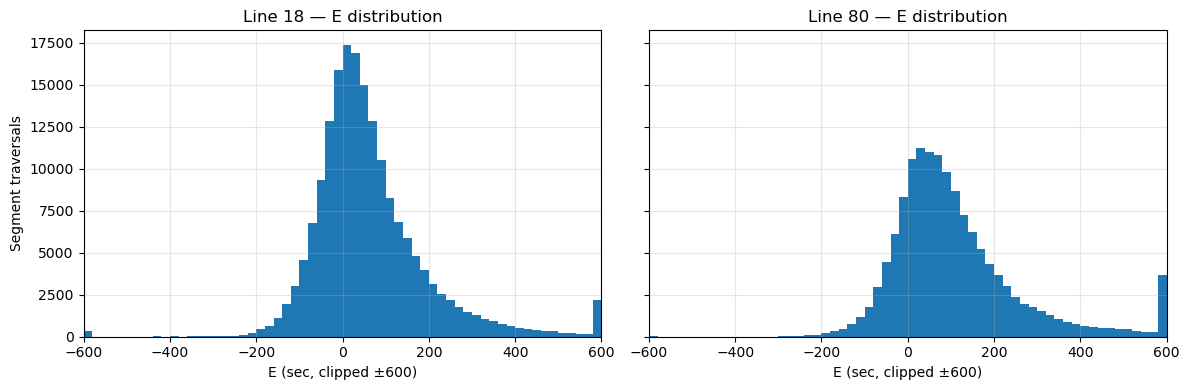

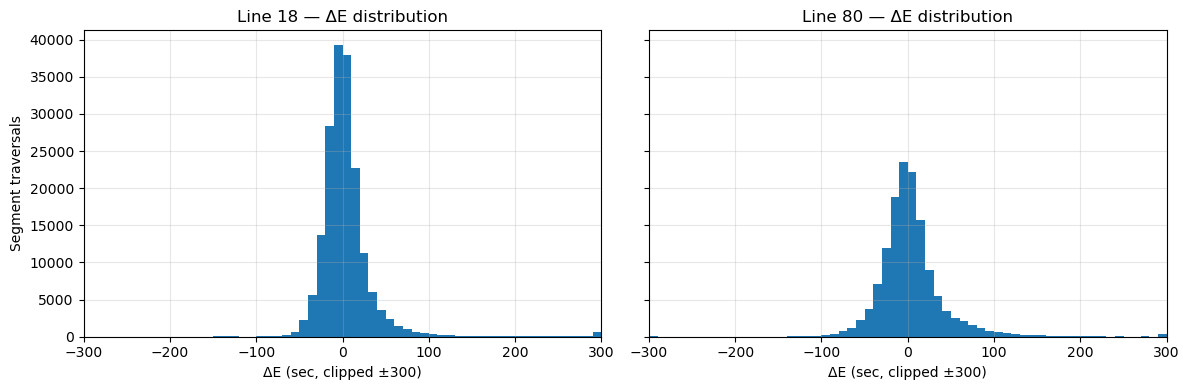

In [72]:
# --- E distribution by line (observation-level) ---
bins_E = np.arange(-E_CLIP, E_CLIP+1, 20)
fig, axs = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

for i, L in enumerate(lines_to_plot):
    dfL = eda[eda["line"] == L]
    axs[i].hist(dfL["E_plot"].dropna(), bins=bins_E)
    finish(axs[i], xlabel="E (sec, clipped ±600)",
           ylabel="Segment traversals" if i==0 else None,
           title=f"Line {L} — E distribution")

axs[0].set_xlim(-E_CLIP, E_CLIP)
plt.tight_layout(); plt.show()

# --- ΔE distribution by line (observation-level) ---
bins_dE = np.arange(-dE_CLIP, dE_CLIP+1, 10)
fig, axs = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

for i, L in enumerate(lines_to_plot):
    dfL = eda[eda["line"] == L]
    axs[i].hist(dfL["dE_plot"].dropna(), bins=bins_dE)
    finish(axs[i], xlabel="ΔE (sec, clipped ±300)",
           ylabel="Segment traversals" if i==0 else None,
           title=f"Line {L} — ΔE distribution")

axs[0].set_xlim(-dE_CLIP, dE_CLIP)
plt.tight_layout(); plt.show()

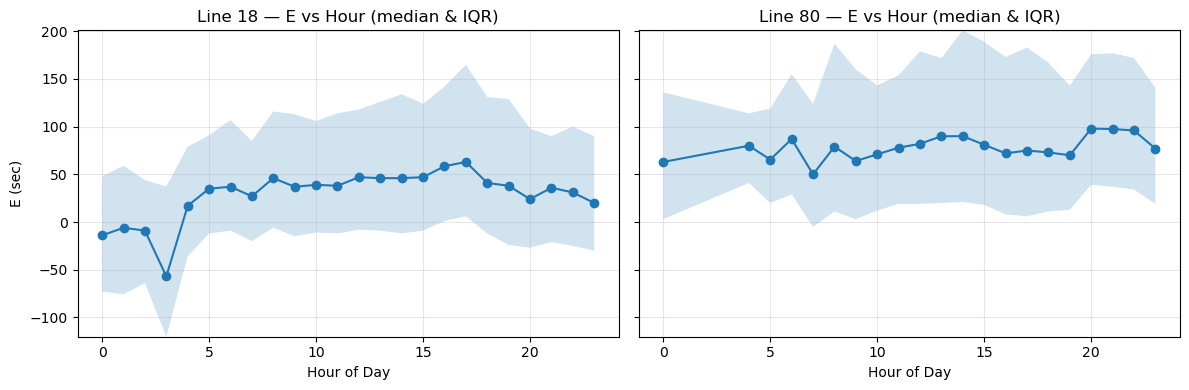

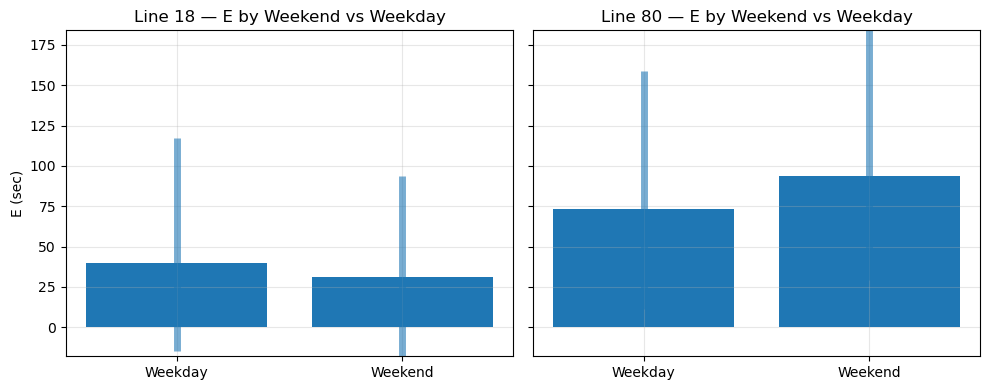

In [71]:
# --- Hour-of-day effect (median & IQR), split by line with same y-limits ---
aggL = {}
for L in lines_to_plot:
    tmp = (eda[eda["line"]==L]
           .dropna(subset=["E_i","link_start_time"])
           .assign(hour=lambda d: d["link_start_time"].dt.hour)
           .groupby("hour")["E_i"]
           .agg(median="median", q25=lambda s: s.quantile(0.25), q75=lambda s: s.quantile(0.75))
           .reset_index())
    aggL[L] = tmp

# get common y-limits
ymin = min(min(v["q25"].min(), v["median"].min()) for v in aggL.values())
ymax = max(max(v["q75"].max(), v["median"].max()) for v in aggL.values())

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
for i, L in enumerate(lines_to_plot):
    tmp = aggL[L]
    axs[i].plot(tmp["hour"], tmp["median"], marker="o")
    axs[i].fill_between(tmp["hour"], tmp["q25"], tmp["q75"], alpha=0.2)
    axs[i].set_ylim(ymin, ymax)
    finish(axs[i], xlabel="Hour of Day", ylabel="E (sec)" if i==0 else None,
           title=f"Line {L} — E vs Hour (median & IQR)")
plt.tight_layout(); plt.show()

# --- Weekend vs Weekday (median + IQR), split by line, same y-limits ---
aggL2 = {}
for L in lines_to_plot:
    tmp = (eda[eda["line"]==L]
           .dropna(subset=["E_i"])
           .groupby("is_weekend")["E_i"]
           .agg(median="median", q25=lambda s: s.quantile(0.25), q75=lambda s: s.quantile(0.75))
           .reset_index())
    tmp["label"] = tmp["is_weekend"].map({0:"Weekday",1:"Weekend"})
    aggL2[L] = tmp

ymin = min(min(v["q25"].min(), v["median"].min()) for v in aggL2.values())
ymax = max(max(v["q75"].max(), v["median"].max()) for v in aggL2.values())

fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)
for i, L in enumerate(lines_to_plot):
    tmp = aggL2[L]
    axs[i].bar(tmp["label"], tmp["median"])
    for j, row in tmp.iterrows():
        axs[i].vlines(j, row["q25"], row["q75"], linewidth=5, alpha=0.6)
    axs[i].set_ylim(ymin, ymax)
    finish(axs[i], xlabel="", ylabel="E (sec)" if i==0 else None,
           title=f"Line {L} — E by Weekend vs Weekday")
plt.tight_layout(); plt.show()

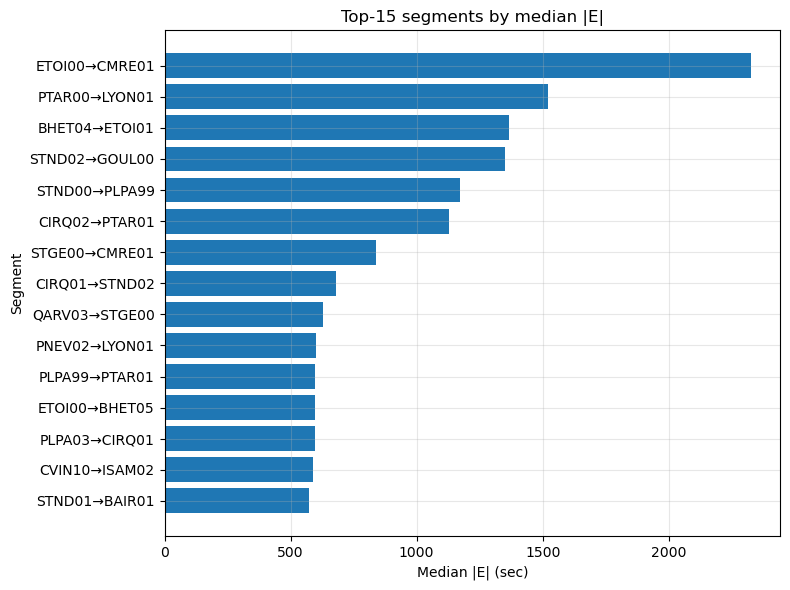

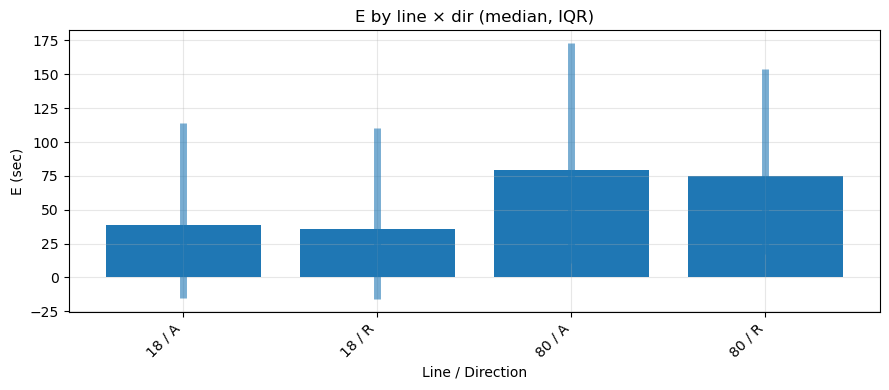

In [66]:
# --- Top segments by median |E| (helps find bottlenecks quickly) ---
tmp = (eda.dropna(subset=["E_i"])
       .assign(absE=lambda d: d["E_i"].abs())
       .groupby("SegmentKey")["absE"].median()
       .sort_values(ascending=False).head(15)
       .reset_index())

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(tmp["SegmentKey"], tmp["absE"])
ax.invert_yaxis()
finish(ax, xlabel="Median |E| (sec)", ylabel="Segment", title="Top-15 segments by median |E|")
plt.tight_layout()
plt.show()

# --- Line / direction effects on E (median, with IQR whiskers) ---
tmp = (eda.dropna(subset=["E_i"])
       .groupby(["line","dir"])["E_i"]
       .agg(median="median", q25=lambda s: s.quantile(0.25), q75=lambda s: s.quantile(0.75))
       .reset_index())
tmp["linedir"] = tmp["line"].astype(str) + " / " + tmp["dir"].astype(str)

fig, ax = plt.subplots(figsize=(9,4))
ax.bar(tmp["linedir"], tmp["median"])
for i, row in tmp.iterrows():
    ax.vlines(i, row["q25"], row["q75"], linewidth=5, alpha=0.6)
finish(ax, xlabel="Line / Direction", ylabel="E (sec)", title="E by line × dir (median, IQR)")
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.show()

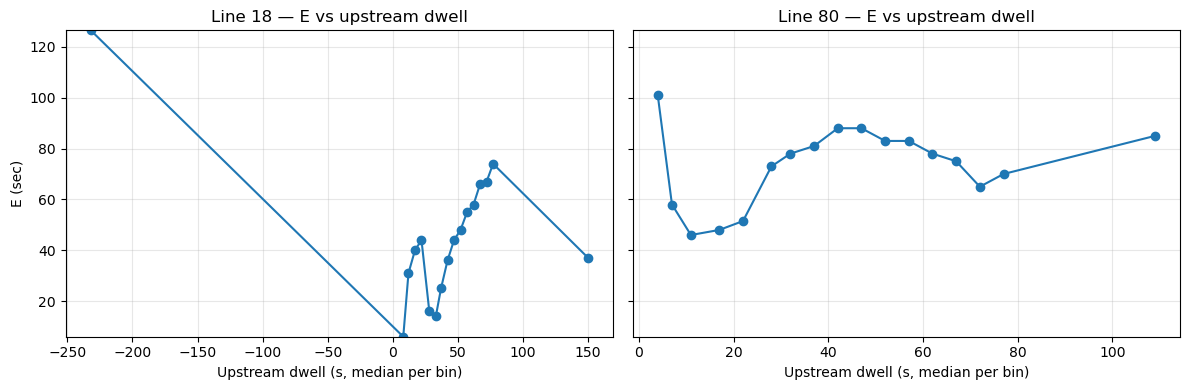

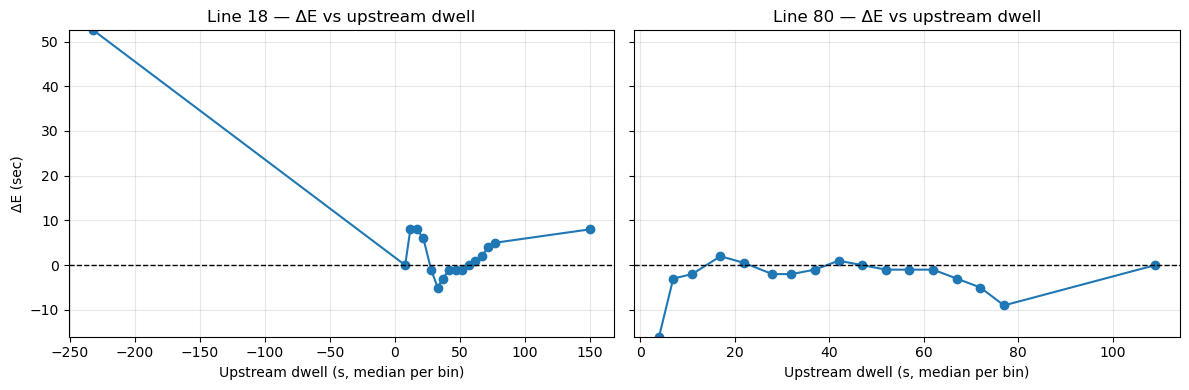

In [74]:
# --- Binned trend: upstream dwell vs E (per line, same y-limits) ---
bins = np.linspace(0, 80, 17)  # 0~80s
curves = {}
for L in lines_to_plot:
    tmp = (eda[eda["line"]==L]
           .dropna(subset=["dwell_prev_s","E_i"])
           .assign(bin=lambda d: np.digitize(d["dwell_prev_s"].clip(0, bins[-1]), bins))
           .groupby("bin")[["dwell_prev_s","E_i"]].median()
           .reset_index(drop=True))
    curves[L] = tmp

ymin = min(v["E_i"].min() for v in curves.values())
ymax = max(v["E_i"].max() for v in curves.values())

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
for i, L in enumerate(lines_to_plot):
    tmp = curves[L]
    axs[i].plot(tmp["dwell_prev_s"], tmp["E_i"], marker="o")
    axs[i].set_ylim(ymin, ymax)
    finish(axs[i], xlabel="Upstream dwell (s, median per bin)",
           ylabel="E (sec)" if i==0 else None,
           title=f"Line {L} — E vs upstream dwell")
plt.tight_layout(); plt.show()

# --- Binned trend: upstream dwell vs ΔE ---
curves_dE = {}
for L in lines_to_plot:
    tmp = (eda[eda["line"]==L]
           .dropna(subset=["dwell_prev_s","dE_plot"])
           .assign(bin=lambda d: np.digitize(d["dwell_prev_s"].clip(0, bins[-1]), bins))
           .groupby("bin")[["dwell_prev_s","dE_plot"]].median()
           .reset_index(drop=True))
    curves_dE[L] = tmp

ymin = min(v["dE_plot"].min() for v in curves_dE.values())
ymax = max(v["dE_plot"].max() for v in curves_dE.values())

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
for i, L in enumerate(lines_to_plot):
    tmp = curves_dE[L]
    axs[i].plot(tmp["dwell_prev_s"], tmp["dE_plot"], marker="o")
    axs[i].axhline(0, ls="--", c="k", lw=1)
    axs[i].set_ylim(ymin, ymax)
    finish(axs[i], xlabel="Upstream dwell (s, median per bin)",
           ylabel="ΔE (sec)" if i==0 else None,
           title=f"Line {L} — ΔE vs upstream dwell")
plt.tight_layout(); plt.show()

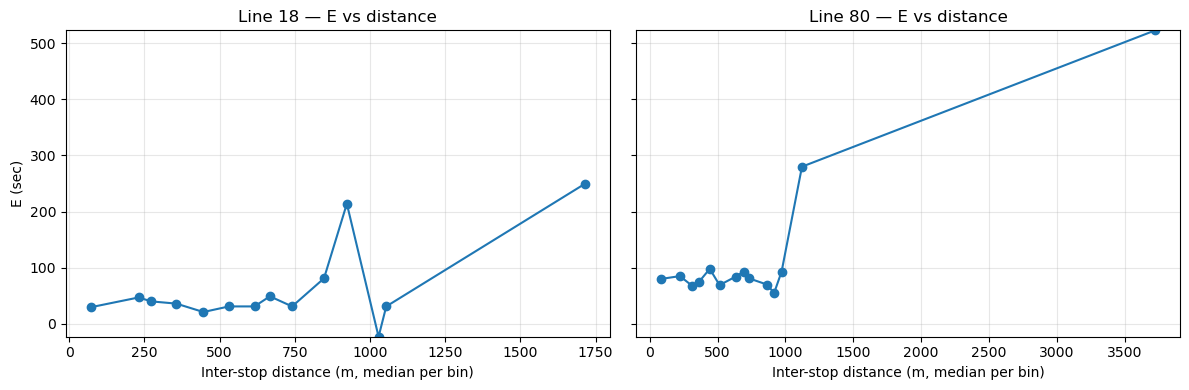

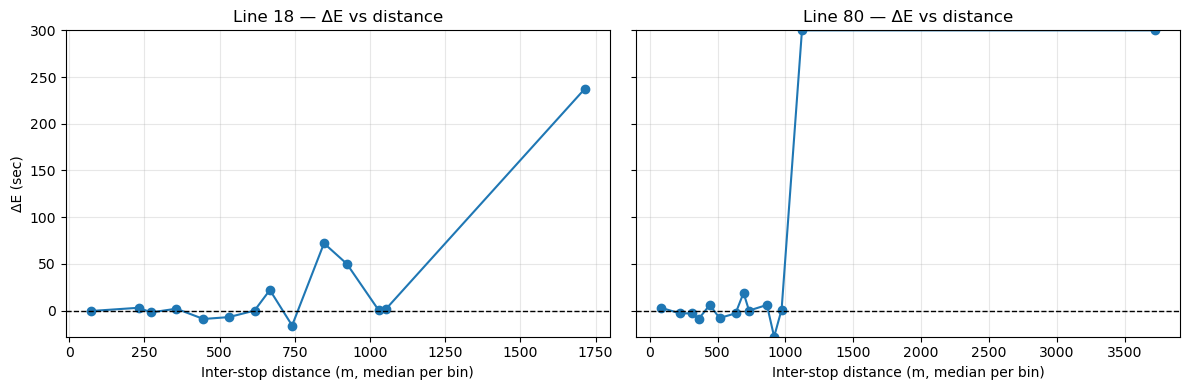

In [75]:
# --- Distance vs E (binned medians), split by line with same y-limits ---
bins = np.linspace(100, 1200, 15)
curves = {}
for L in lines_to_plot:
    tmp = (eda[eda["line"]==L]
           .dropna(subset=["distance_m","E_i"])
           .assign(bin=lambda d: np.digitize(d["distance_m"].clip(bins[0], bins[-1]), bins))
           .groupby("bin")[["distance_m","E_i"]].median()
           .reset_index(drop=True))
    curves[L] = tmp

ymin = min(v["E_i"].min() for v in curves.values())
ymax = max(v["E_i"].max() for v in curves.values())

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
for i, L in enumerate(lines_to_plot):
    tmp = curves[L]
    axs[i].plot(tmp["distance_m"], tmp["E_i"], marker="o")
    axs[i].set_ylim(ymin, ymax)
    finish(axs[i], xlabel="Inter-stop distance (m, median per bin)",
           ylabel="E (sec)" if i==0 else None,
           title=f"Line {L} — E vs distance")
plt.tight_layout(); plt.show()

# --- Distance vs ΔE (binned medians), split by line ---
curves_dE = {}
for L in lines_to_plot:
    tmp = (eda[eda["line"]==L]
           .dropna(subset=["distance_m","dE_plot"])
           .assign(bin=lambda d: np.digitize(d["distance_m"].clip(bins[0], bins[-1]), bins))
           .groupby("bin")[["distance_m","dE_plot"]].median()
           .reset_index(drop=True))
    curves_dE[L] = tmp

ymin = min(v["dE_plot"].min() for v in curves_dE.values())
ymax = max(v["dE_plot"].max() for v in curves_dE.values())

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
for i, L in enumerate(lines_to_plot):
    tmp = curves_dE[L]
    axs[i].plot(tmp["distance_m"], tmp["dE_plot"], marker="o")
    axs[i].axhline(0, ls="--", c="k", lw=1)
    axs[i].set_ylim(ymin, ymax)
    finish(axs[i], xlabel="Inter-stop distance (m, median per bin)",
           ylabel="ΔE (sec)" if i==0 else None,
           title=f"Line {L} — ΔE vs distance")
plt.tight_layout(); plt.show()